In [1]:
#importing libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
#MNIST -> hand written digits
#0 to 255 -> 0 to 1 
# assume they are transformed from (0, 1)
# min value = (0 - 0.5) / 0.5 = -1
# max value = (1 - 0.5) / 0.5 = +1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

In [3]:
#downloading the dataset
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
#Shape of the dataset
len(train_dataset)

60000

In [5]:
# Preparing the model
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [6]:
# Discriminator ANN
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    # nn.Sigmoid()
)

In [7]:
# Generator
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),     #28*28 -> image size of MNIST dataset
    nn.Tanh()    #-> -1 to 1     
)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# scale image back to (0, 1)
def scale_image(img):
  out = (img + 1) / 2   # -1 and 1 =>-1+1/2 = 0 and 1+1/2 =1
  return out

In [11]:
# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
# Training loop

# labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

# save losses
d_losses = []
g_losses = []

for epoch in range(200):
  for inputs, _ in data_loader:
    # don't need targets

    # reshape and move to GPU
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    # set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]


    ###########################
    ### Train discriminator ###
    ###########################

    # real images
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    # fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    # gradient descent step
    d_loss = 0.5 * (d_loss_real + d_loss_fake) # real_loss+fake_loss/2
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    #######################
    ### Train generator ###
    #######################

    # do it twice:
    for _ in range(2):
      # fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images) #-> 0

      # reverse the labels!
      g_loss = criterion(fake_outputs, ones) #-> 1

      # gradient descent step
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())


  ### print and save things ###
  print(f"Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

  # PyTorch has a function to save a batch of images to file
  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f"gan_images/{epoch+1}.png")

Epoch: 0, d_loss: 0.6774535775184631, g_loss: 0.6915645599365234
Epoch: 1, d_loss: 0.6775370836257935, g_loss: 0.7191166877746582
Epoch: 2, d_loss: 0.6639036536216736, g_loss: 0.7685429453849792
Epoch: 3, d_loss: 0.6635621786117554, g_loss: 0.8378428220748901
Epoch: 4, d_loss: 0.6924730539321899, g_loss: 0.7105058431625366
Epoch: 5, d_loss: 0.6771416664123535, g_loss: 0.6858085989952087
Epoch: 6, d_loss: 0.6876533031463623, g_loss: 0.7357231974601746
Epoch: 7, d_loss: 0.6799811124801636, g_loss: 0.8019652366638184
Epoch: 8, d_loss: 0.7048765420913696, g_loss: 0.70152348279953
Epoch: 9, d_loss: 0.6812350749969482, g_loss: 0.7374727725982666
Epoch: 10, d_loss: 0.6858258843421936, g_loss: 0.693205714225769
Epoch: 11, d_loss: 0.6708396673202515, g_loss: 0.7170960903167725
Epoch: 12, d_loss: 0.6723779439926147, g_loss: 0.7859138250350952
Epoch: 13, d_loss: 0.6913808584213257, g_loss: 0.703828752040863
Epoch: 14, d_loss: 0.6838310360908508, g_loss: 0.6930224299430847
Epoch: 15, d_loss: 0.687

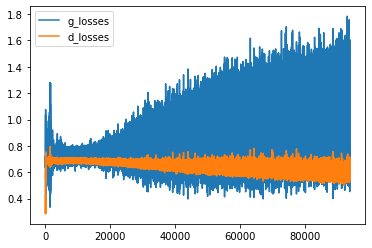

In [13]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

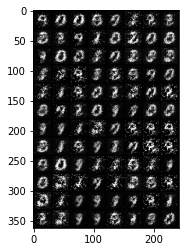

In [14]:
from skimage.io import imread
a = imread('gan_images/1.png')
plt.imshow(a)

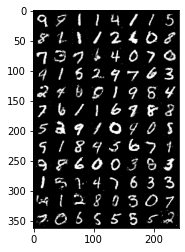

In [15]:
a = imread('gan_images/50.png')
plt.imshow(a)

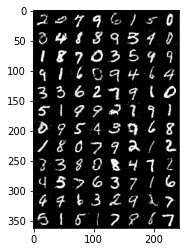

In [16]:
a = imread('gan_images/100.png')
plt.imshow(a)

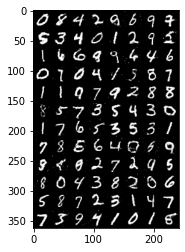

In [17]:
a = imread('gan_images/127.png')
plt.imshow(a)

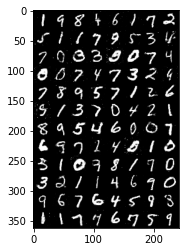

In [18]:
a = imread('gan_images/200.png')
plt.imshow(a)